# Bidirection Compression


## 1. Implement an environment that would emulate the communication of workers with the server


In [12]:
import time
import numpy as np
from sklearn.utils import gen_batches
import abc
from dataclasses import dataclass
from typing import List


class ServerToWorkerCompressor(metaclass=abc.ABCMeta):
    def __init__(self, compression_ratio):
        self.compression_ratio = compression_ratio
        self.transmitted_coordinates = 0

    @abc.abstractmethod
    def compress(self, X, y):
        pass

    @abc.abstractmethod
    def decompress(self, X, y):
        pass


class WorkerToServerCompressor(metaclass=abc.ABCMeta):
    def __init__(self, compression_ratio):
        self.compression_ratio = compression_ratio
        self.transmitted_coordinates = 0

    @abc.abstractmethod
    def compress(self, gradient_device):
        pass

    def decompress(self, gradient_device, selected_indices, original_size):
        decompressed = np.zeros(original_size)
        decompressed[selected_indices] = gradient_device
        return decompressed

    def omega(self, gradient_device):
        k = max(1, int(len(gradient_device) * self.compression_ratio))
        return len(gradient_device) / k - 1


class NoopServerToWorkerCompressor(ServerToWorkerCompressor):
    def __init__(self):
        super().__init__(0)

    def compress(self, X, y):
        self.transmitted_coordinates += X.shape[0] * X.shape[1] + y.shape[0]
        return X, y

    def decompress(self, X, y):
        return X, y


class Device:
    def __init__(
        self,
        env,
        n_features,
    ):
        self.n_features = n_features
        self.weights = np.zeros(n_features)
        self.env = env

    def execute(self, X_compressed, y_compressed, L, n_devices, iteration):
        X, y = self.env.server_to_worker_compressor.decompress(X_compressed, y_compressed)

        lambda_reg = L / 1000
        gradient_device = self.env.nabla_f(X, y, self.weights, lambda_reg)

        gamma = self.env.gamma_k(L, self.env.worker_to_server_compressor.omega(gradient_device), n_devices, iteration)
        self.weights -= gamma * gradient_device

        compressed_gradient, indices = self.env.worker_to_server_compressor.compress(gradient_device)

        return compressed_gradient, indices


@dataclass
class SimulationState:
    n_features: int
    weights: np.ndarray
    devices: List[Device]
    convergence: List[float]
    accuracies: List[float]
    execution_time: float
    L: float
    transmitted_coordinates_worker_to_server: int = 0
    transmitted_coordinates_server_to_worker: int = 0


class DistributedEnvSimulator:
    def __init__(
        self,
        nabla_f,
        gamma_k,
        worker_to_server_compressor,
        server_to_worker_compressor=NoopServerToWorkerCompressor(),
    ):
        self.nabla_f = nabla_f
        self.gamma_k = gamma_k
        self.worker_to_server_compressor = worker_to_server_compressor
        self.server_to_worker_compressor = server_to_worker_compressor

    def simulate_distributed_env(
        self,
        X,
        y,
        n_devices,
        num_iterations=100,
        eps=None,
    ):
        state = self._init_simulation(X, n_devices)

        X_split, y_split = self._split_data(X, y, int(X.shape[0] / n_devices))

        for iteration in range(num_iterations):
            start_time = time.time()
            aggregated_gradient = np.zeros(state.n_features)

            for device_idx in range(n_devices):
                batch_idx = np.random.randint(0, n_devices)

                X_device = X_split[batch_idx]
                y_device = y_split[batch_idx]
                device = state.devices[device_idx]

                X_compressed, y_compressed = self.server_to_worker_compressor.compress(X_device, y_device)

                compressed_gradient, indices = device.execute(X_compressed, y_compressed, state.L, n_devices, iteration)

                aggregated_gradient += self.worker_to_server_compressor.decompress(
                    compressed_gradient, indices, state.n_features
                )

            gamma = self.gamma_k(
                state.L, self.worker_to_server_compressor.omega(aggregated_gradient), n_devices, iteration
            )
            state.weights -= gamma * (aggregated_gradient / n_devices)
            state.execution_time += time.time() - start_time

            accuracy_i = self._estimate_accuracy(X, y, state.weights)
            state.accuracies.append(accuracy_i)
            convergence_i = self._estimate_convergence(aggregated_gradient, n_devices)
            state.convergence.append(convergence_i)

            if eps is not None and accuracy_i < eps:
                break

        state.transmitted_coordinates_worker_to_server = self.worker_to_server_compressor.transmitted_coordinates
        state.transmitted_coordinates_server_to_worker = self.server_to_worker_compressor.transmitted_coordinates

        return state

    def _init_simulation(self, X, n_devices):
        n_features = X.shape[1]
        weights = np.zeros(n_features)
        devices = [self._create_device(self, n_features) for _ in range(n_devices)]
        convergence = []
        accuracies = []
        execution_time = 0

        L = np.sum(np.linalg.vector_norm(X, axis=1) ** 2) / (4 * X.shape[1])

        return SimulationState(n_features, weights, devices, convergence, accuracies, execution_time, L)

    def _estimate_accuracy(self, X, y, weights):
        y_pred = np.sign(np.dot(X, weights))
        diff = y.astype("int") - y_pred.astype("int")
        false_predictions = len(diff[diff != 0])
        accuracy = 1 - false_predictions / len(y_pred)
        return accuracy

    def _estimate_convergence(self, aggregated_gradient, n_devices):
        return np.linalg.norm(aggregated_gradient / n_devices)

    def _create_device(self, *args):
        return Device(*args)

    def _split_data(self, X, y, batch_size):
        X_batched = []
        y_batched = []
        for batch_indices in gen_batches(n=len(X), batch_size=batch_size, min_batch_size=batch_size):
            X_batched.append(X[batch_indices])
            y_batched.append(y[batch_indices])
        return X_batched, y_batched

## 2. Implement CGD


In [13]:
class RandKWorkerToServerCompressor(WorkerToServerCompressor):
    def compress(self, vector):
        k = max(1, int(len(vector) * self.compression_ratio))

        selected_indices = np.random.choice(len(vector), size=k, replace=False)

        compressed = np.zeros(len(selected_indices))
        compressed = vector[selected_indices]

        self.transmitted_coordinates += len(compressed)

        return compressed, selected_indices

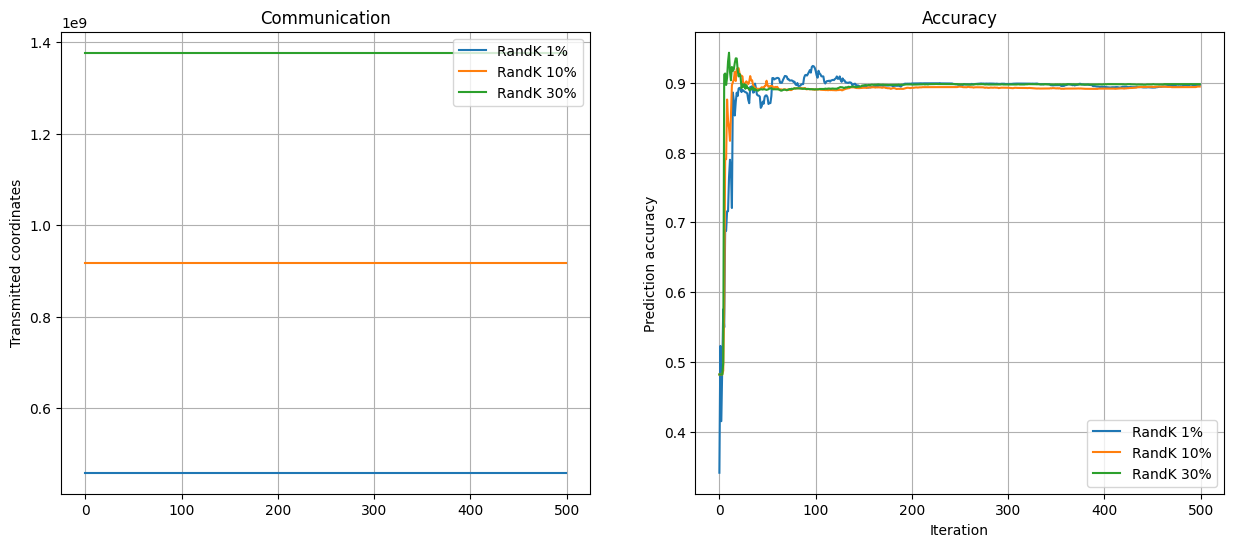

In [14]:
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

n_devices = 10
compression_ratios = [0.01, 0.10, 0.30]
num_iterations = 500


def nabla_f(X, y, w, lambda_reg):
    ratio = -y / (1 + np.exp(y * (X @ w)))
    gradient = np.mean(ratio.reshape(-1, 1) * X, axis=0) + lambda_reg * w
    return gradient / X.shape[1]


def gamma_k(L, omega, n_devices, iteration):
    return 1 / (L * (2 * omega / n_devices + 1))


plt.figure(figsize=(15, 6))

for ratio in compression_ratios:
    randk_worker_to_server_compressor = RandKWorkerToServerCompressor(ratio)
    randk_simulator = DistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        worker_to_server_compressor=randk_worker_to_server_compressor,
    )
    randk_res = randk_simulator.simulate_distributed_env(
        X=X,
        y=y,
        n_devices=n_devices,
        num_iterations=num_iterations,
    )

    plt.subplot(1, 2, 1)
    plt.plot(
        np.full(
            len(randk_res.accuracies),
            randk_res.transmitted_coordinates_server_to_worker + randk_res.transmitted_coordinates_worker_to_server,
        ),
        label=f"RandK {int(ratio*100)}%",
    )

    plt.subplot(1, 2, 2)
    plt.plot(np.array(randk_res.accuracies), label=f"RandK {int(ratio*100)}%")

plt.subplot(1, 2, 1)
plt.ylabel("Transmitted coordinates")
plt.grid(True)
plt.legend()
plt.title("Communication")

plt.subplot(1, 2, 2)
plt.xlabel("Iteration")
plt.ylabel("Prediction accuracy")
plt.grid(True)
plt.legend()
plt.title("Accuracy")

plt.show()

## 3. EF21-P + DIANA


In [15]:
class DianaServerToWorkerCompressor(ServerToWorkerCompressor):
    pass

TypeError: Can't instantiate abstract class DianaServerToWorkerCompressor without an implementation for abstract methods 'compress', 'decompress'

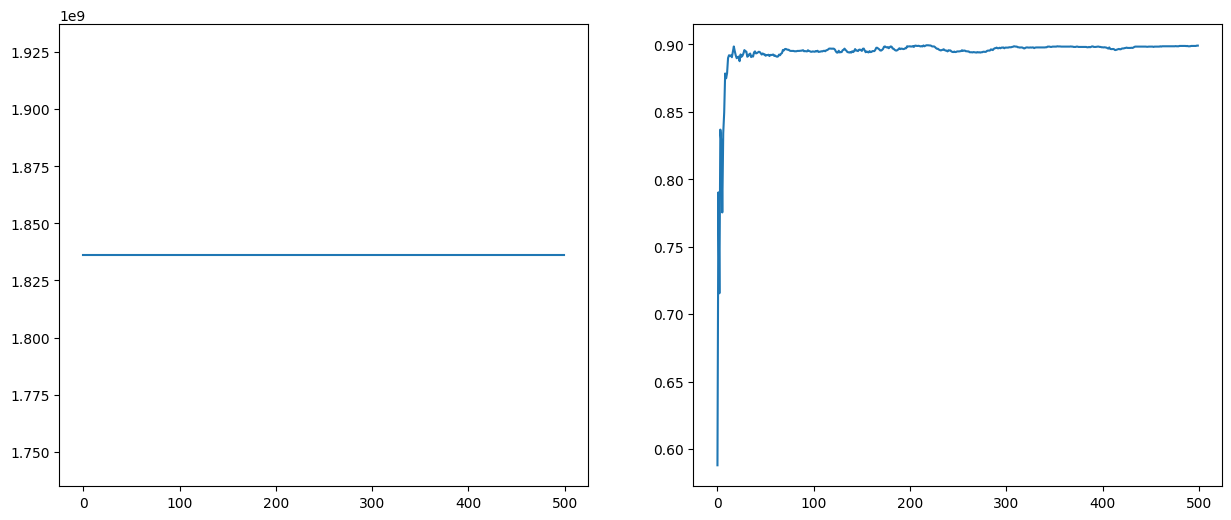

In [16]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

n_devices = 10
worker_to_server_compression_ratio = 0.05
compression_ratios = [0.01, 0.10, 0.30]
num_iterations = 500


def nabla_f(X, y, w, lambda_reg):
    ratio = -y / (1 + np.exp(y * (X @ w)))
    gradient = np.mean(ratio.reshape(-1, 1) * X, axis=0) + lambda_reg * w
    return gradient / X.shape[1]


def gamma_k(L, omega, n_devices, iteration):
    return 1 / (L * (2 * omega / n_devices + 1))


plt.figure(figsize=(15, 6))


randk_worker_to_server_compressor = RandKWorkerToServerCompressor(worker_to_server_compression_ratio)
randk_simulator = DistributedEnvSimulator(
    nabla_f=nabla_f,
    gamma_k=gamma_k,
    worker_to_server_compressor=randk_worker_to_server_compressor,
)
randk_res = randk_simulator.simulate_distributed_env(
    X=X,
    y=y,
    n_devices=n_devices,
    num_iterations=num_iterations,
)
plt.subplot(1, 2, 1)
plt.plot(
    np.full(
        len(randk_res.accuracies),
        randk_res.transmitted_coordinates_server_to_worker + randk_res.transmitted_coordinates_worker_to_server,
    ),
    label=f"RandK {int(worker_to_server_compression_ratio*100)}%",
)

plt.subplot(1, 2, 2)
plt.plot(np.array(randk_res.accuracies), label=f"RandK {int(worker_to_server_compression_ratio*100)}%")

for ratio in compression_ratios:
    diana_server_to_worker_compressor = DianaServerToWorkerCompressor(ratio)
    diana_simulator = DistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        worker_to_server_compressor=randk_worker_to_server_compressor,
        server_to_worker_compressor=diana_server_to_worker_compressor,
    )
    diana_res = diana_simulator.simulate_distributed_env(
        X=X,
        y=y,
        n_devices=n_devices,
        num_iterations=num_iterations,
    )

    plt.subplot(1, 2, 1)
    plt.plot(
        np.full(
            len(diana_res.accuracies),
            diana_res.transmitted_coordinates_server_to_worker + diana_res.transmitted_coordinates_worker_to_server,
        ),
        label=f"Diana {int(ratio*100)}%",
    )

    plt.subplot(1, 2, 2)
    plt.plot(np.array(diana_res.accuracies), label=f"Diana {int(ratio*100)}%")

plt.subplot(1, 2, 1)
plt.ylabel("Transmitted coordinates")
plt.grid(True)
plt.legend()
plt.title("Communication")

plt.subplot(1, 2, 2)
plt.xlabel("Iteration")
plt.ylabel("Prediction accuracy")
plt.grid(True)
plt.legend()
plt.title("Accuracy")

plt.show()

## EF21-P + DGCD


In [ ]:
class DCGDServerToWorkerCompressor(ServerToWorkerCompressor):
    pass

In [ ]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

n_devices = 10
worker_to_server_compression_ratio = 0.05
compression_ratios = [0.01, 0.10, 0.30]
num_iterations = 500


def nabla_f(X, y, w, lambda_reg):
    ratio = -y / (1 + np.exp(y * (X @ w)))
    gradient = np.mean(ratio.reshape(-1, 1) * X, axis=0) + lambda_reg * w
    return gradient / X.shape[1]


def gamma_k(L, omega, n_devices, iteration):
    return 1 / (L * (2 * omega / n_devices + 1))


plt.figure(figsize=(15, 6))


randk_worker_to_server_compressor = RandKWorkerToServerCompressor(worker_to_server_compression_ratio)
randk_simulator = DistributedEnvSimulator(
    nabla_f=nabla_f,
    gamma_k=gamma_k,
    worker_to_server_compressor=randk_worker_to_server_compressor,
)
(
    randk_weights,
    randk_convergence,
    randk_accuracies,
    randk_execution_time,
    randk_transmitted_coordinates_worker_to_server,
    randk_transmitted_coordinates_server_to_worker,
) = randk_simulator.simulate_distributed_env(
    X=X,
    y=y,
    n_devices=n_devices,
    num_iterations=num_iterations,
)
plt.subplot(1, 2, 1)
plt.plot(
    np.full(
        len(randk_accuracies),
        randk_transmitted_coordinates_server_to_worker + randk_transmitted_coordinates_worker_to_server,
    ),
    label=f"RandK {int(worker_to_server_compression_ratio*100)}%",
)

plt.subplot(1, 2, 2)
plt.plot(np.array(randk_accuracies), label=f"RandK {int(worker_to_server_compression_ratio*100)}%")

for ratio in compression_ratios:
    dcgd_server_to_worker_compressor = DCGDServerToWorkerCompressor(ratio)
    dcgd_simulator = DistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        worker_to_server_compressor=randk_worker_to_server_compressor,
        server_to_worker_compressor=dcgd_server_to_worker_compressor,
    )
    (
        dcgd_weights,
        dcgd_convergence,
        dcgd_accuracies,
        dcgd_execution_time,
        dcgd_transmitted_coordinates_worker_to_server,
        dcgd_transmitted_coordinates_server_to_worker,
    ) = dcgd_simulator.simulate_distributed_env(
        X=X,
        y=y,
        n_devices=n_devices,
        num_iterations=num_iterations,
    )

    plt.subplot(1, 2, 1)
    plt.plot(
        np.full(
            len(dcgd_accuracies),
            dcgd_transmitted_coordinates_server_to_worker + dcgd_transmitted_coordinates_worker_to_server,
        ),
        label=f"DGCD {int(ratio*100)}%",
    )

    plt.subplot(1, 2, 2)
    plt.plot(np.array(dcgd_accuracies), label=f"DCGD {int(ratio*100)}%")

plt.subplot(1, 2, 1)
plt.ylabel("Transmitted coordinates")
plt.grid(True)
plt.legend()
plt.title("Communication")

plt.subplot(1, 2, 2)
plt.xlabel("Iteration")
plt.ylabel("Prediction accuracy")
plt.grid(True)
plt.legend()
plt.title("Accuracy")

plt.show()